In [ ]:
# !pip install scikit-image

In [19]:
# Standard library imports
import os
import re
import random
import shutil
from datetime import datetime
from collections import OrderedDict

# Data handling and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch and TorchVision libraries for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.models as models
from torchvision import transforms, datasets
from PIL import Image

# Scikit-Learn for evaluation metrics and data splitting|
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Imbalanced-learn for oversampling to address class imbalance
from imblearn.over_sampling import RandomOverSampler

from torchvision import transforms
from torchvision.transforms import functional as F
from PIL import Image
from PIL import UnidentifiedImageError
from tqdm import tqdm

import os, re, random
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
from google.colab import drive

from skimage import color


In [20]:
# ─── 1) MOUNT GOOGLE DRIVE ──────────────────────────────────────────────
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [21]:
# ─── LOAD LABELS & BUILD CLASS MAP ───────────────────────────────────────
labels = pd.read_csv(
    "/content/drive/MyDrive/case_grade_match.csv"
).drop(index=64, errors='ignore').reset_index(drop=True)

In [22]:
# Note that case 65 is not included in the analysis as it was not labelled
labels.loc[62:65,:]

,Case,Class
62,63,3
63,64,3
64,66,3
65,67,4


In [23]:
filtered_patches_dir = '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27'
os.path.exists(filtered_patches_dir)

True

In [24]:
test_image = '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_1_match_1_h&e_patch0.png'

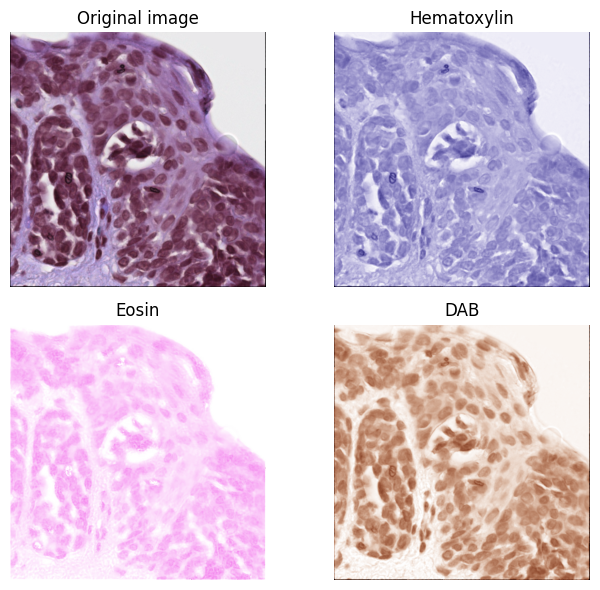

In [ ]:
from skimage.color import rgb2hed, hed2rgb

rgb_img = Image.open(test_image).convert('RGB')

# Separate the stains from the IHC image
ihc_hed = rgb2hed(rgb_img)

# Create an RGB image for each of the stains
null = np.zeros_like(ihc_hed[:, :, 0])
ihc_h = hed2rgb(np.stack((ihc_hed[:, :, 0], null, null), axis=-1))
ihc_e = hed2rgb(np.stack((null, ihc_hed[:, :, 1], null), axis=-1))
ihc_d = hed2rgb(np.stack((null, null, ihc_hed[:, :, 2]), axis=-1))

# Display
fig, axes = plt.subplots(2, 2, figsize=(7, 6), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(rgb_img)
ax[0].set_title("Original image")

ax[1].imshow(ihc_h)
ax[1].set_title("Hematoxylin")

ax[2].imshow(ihc_e)
ax[2].set_title("Eosin")  # Note that there is no Eosin stain in this image

ax[3].imshow(ihc_d)
ax[3].set_title("DAB")

for a in ax.ravel():
    a.axis('off')

fig.tight_layout()

In [25]:
filtered_patches_dir = '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27'

if os.path.exists("/content/drive/MyDrive/patch_dir.npy"):
    all_files = np.load("/content/drive/MyDrive/patch_dir.npy", allow_pickle=True).tolist()
else:
    all_files = os.listdir('/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27')

len(all_files)

83717

In [26]:
# === Slice-Level Grouping ===

# Edit 10/19: identified scenario where patches are not being matched:
#     1) missing space between 'match' / 'unmatched' and number, eg. case_38_match14_h&e_patch25.png
#     2) Additionally, some names include 'labels' (not relevant to this regex which is only looking at case matching but thought I would flag),
#         eg. case_82_unmatched3_h&e-labels_patch32.png
def group_patches_by_slice(root_dir):
    case_slices = defaultdict(list)
    # list of unconventionally-named patches
    invalid_file_names = []
    flexibility_needed_counter = 0
    for root, _, files in os.walk(root_dir):
        for filename in files:
            if filename.endswith(".png"):
              #  match = re.match(r"case_(\d+)_([\w&\-]+_\d+)_", filename)
                match = re.match(r"case_(\d+)_([a-z]+_\d+)_", filename) #check if some patches are named differently
                if match:
                    case_id = int(match.group(1))
                    slice_id = match.group(2)
                    key = (case_id, slice_id)
                    case_slices[key].append(os.path.join(root, filename))

                    continue
                # if a file doesn't match, try regex without "_" between "match" / "unmatched" and number
                match = re.match(r"case_(\d+)_([a-z]+\d+)_", filename)
                if match:
                    case_id = int(match.group(1))
                    slice_id = match.group(2)
                    # adding underscore between "match" / "unmatched" and number
                    slice_id = re.sub(r'([A-Za-z])(\d)', r'\1_\2', slice_id)
                    key = (case_id, slice_id)
                    case_slices[key].append(os.path.join(root, filename))
                    flexibility_needed_counter += 1

                    continue
                invalid_file_names.append(os.path.join(root, filename))

    # Print summary of invalid files
    if invalid_file_names:
        print(f"Found {len(invalid_file_names)} files not following naming convention:")
        for f in invalid_file_names:
            print("  ", f)
    else:
        print(f"All {flexibility_needed_counter} invalid file names were handled.")
    return case_slices

In [27]:
# === Load Patches by Slice ===
patches = group_patches_by_slice(filtered_patches_dir)

All 3808 invalid file names were handled.


In [28]:
len(patches)

378

In [29]:
tot_patches = 0
for ke in patches.keys():
  tot_patches = tot_patches + len(patches[ke])
tot_patches

83717

Some patches are getting lost (need to make the 'match = re.match(....)' code more general)

In [30]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [31]:
# Training transform (augmented)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [32]:
# === Build Label Map by Slice ===
slice_to_class = {}
valid_classes = [1.0, 3.0, 4.0]
for (case_id, slice_id), paths in patches.items():
    raw_label = labels.loc[labels['Case'] == case_id, 'Class']
    if not raw_label.empty and raw_label.item() in valid_classes:
        label = 0 if raw_label.item() == 1.0 else 1
        slice_to_class[(case_id, slice_id)] = label

In [33]:
len(slice_to_class) # Low-grade slices are removed

366

In [34]:
slice_to_class[(106, 'match_1')]

1

In [35]:
# === Stratified Split by Slice ===
slices_by_class = defaultdict(list)
for key, label in slice_to_class.items():
    slices_by_class[label].append(key) # Dictonary of length 2

In [36]:
slices_by_class.keys()

dict_keys([1, 0])

In [37]:
# number of cases
unique_case = {t[0] for v in slices_by_class.values() for t in v}
len(unique_case)

86

In [38]:
def split_by_case_stratified(slices_by_class, random_state=42):
    # 1) Build case -> label map and validate no mixed-label cases
    case_to_labels = defaultdict(set)
    for label, items in slices_by_class.items():
        for case_id, _ in items:
            case_to_labels[case_id].add(label)
    mixed = {cid: labs for cid, labs in case_to_labels.items() if len(labs) > 1}
    if mixed:
        raise ValueError(f"Found cases with mixed labels (would cause leakage): {mixed}")

    # Flatten to case list and aligned labels
    case_ids = []
    case_labels = []
    for cid, labs in case_to_labels.items():
        case_ids.append(cid)
        case_labels.append(next(iter(labs)))  # the single label for this case

    # 2) Split *cases* with stratification by case-level label
    # 60% train, 40% temp
    case_train, case_temp, y_train, y_temp = train_test_split(
        case_ids, case_labels, test_size=0.4, stratify=case_labels, random_state=random_state
    )
    # temp -> 50/50 to make 20%/20% val/test
    case_val, case_test, _, _ = train_test_split(
        case_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=random_state
    )

    case_train = set(case_train)
    case_val   = set(case_val)
    case_test  = set(case_test)

    # 3) Map case splits back to slice-level lists (no leakage)
    train_slices, val_slices, test_slices = [], [], []
    for label, items in slices_by_class.items():
        for case_id, slice_key in items:
            if case_id in case_train:
                train_slices.append((case_id, slice_key))
            elif case_id in case_val:
                val_slices.append((case_id, slice_key))
            elif case_id in case_test:
                test_slices.append((case_id, slice_key))
            # else: shouldn't happen

    return train_slices, val_slices, test_slices

train_slices, val_slices, test_slices = split_by_case_stratified(slices_by_class)


In [39]:
# check train, test and validation set doesnt have overlapping cases
set([slice[0] for slice in train_slices]) & set([slice[0] for slice in test_slices]) & set([slice[0] for slice in val_slices])

set()

In [40]:
# number of cases after spliting
len(set([slice[0] for slice in train_slices]) | set([slice[0] for slice in test_slices]) | set([slice[0] for slice in val_slices]))

86

In [41]:
train_patches = {k: patches[k] for k in train_slices}
val_patches   = {k: patches[k] for k in val_slices}
test_patches  = {k: patches[k] for k in test_slices}

In [42]:
# === Filter to H&E Only ===

def filter_by_stain(d, keyword):
    out, dropped = {}, []
    for k, paths in d.items():
        filtered = [p for p in paths if keyword.lower() in os.path.basename(p).lower()]
        if filtered:
            out[k] = filtered
        else:
            dropped.append(k)
    if dropped:
        print(f"⚠️ Dropped slices with no '{keyword}' patches: {dropped}")
    return out


train_patches = filter_by_stain(train_patches, "h&e")
val_patches   = filter_by_stain(val_patches, "h&e")
test_patches  = filter_by_stain(test_patches, "h&e")

⚠️ Dropped slices with no 'h&e' patches: [(18, 'unmatched_4'), (87, 'unmatched_2'), (24, 'unmatched_9'), (24, 'unmatched_10'), (22, 'unmatched_12'), (22, 'unmatched_13'), (27, 'unmatched_9'), (27, 'unmatched_8'), (27, 'unmatched_1'), (27, 'match_2'), (23, 'match_1')]
⚠️ Dropped slices with no 'h&e' patches: [(72, 'unmatched_5'), (73, 'unmatched_3'), (15, 'unmatched_11'), (15, 'unmatched_10'), (15, 'unmatched_12'), (15, 'unmatched_13'), (15, 'match_1'), (15, 'match_2'), (72, 'unmatched_6'), (73, 'unmatched_4'), (50, 'match_5'), (50, 'match_4'), (21, 'unmatched_4'), (21, 'match_1')]
⚠️ Dropped slices with no 'h&e' patches: [(104, 'match_15'), (38, 'match_27'), (38, 'match_28'), (38, 'match_29'), (38, 'match_22')]


In [43]:
len(train_patches)

197

In [48]:
# === MILDataset with slice-level keys ===
class SliceMILDataset(Dataset):
    def __init__(self, patch_dict, label_map, transform=None, emergency_cap=800):
      #emergency_cap: upper limit on how many patches per bag to include, why have a limit? how set the limit?
      #If a bag has too many patches (say 3000), only randomly keeps up to emergency_cap (default 800)
      #Prevents out-of-memory errors during training. - needed or not?
      #transform: optional torchvision transform (e.g., resizing, normalization) - same as manual?
        self.transform = transform
        self.emergency_cap = emergency_cap
        # self.bags: list of lists of image paths (each “bag” = slice).
        # self.labels: list of corresponding labels for each bag.
        self.bags, self.labels = [], []
        for slice_key, paths in patch_dict.items():
            self.bags.append(paths)
            self.labels.append(label_map[slice_key])

    # Required for PyTorch datasets — tells how many samples (bags) exist.
    # Enables len(dataset) to work and is used by DataLoader for batching.
    def __len__(self): return len(self.bags)


    # # The method below is called whenever PyTorch asks for a sample.
    # # Retrieves the list of patch file paths for that bag.
    # def __getitem__(self, idx):
    #     paths = self.bags[idx] # idx is the index of the bag you want.
    #     imgs = []
    #     for p in paths:   # Loops through each patch path in the bag.
    #         try:
    #             img = Image.open(p).convert('RGB')
    #             if self.transform: # Applies transforms if provided (resize, normalize, etc.)
    #                 img = self.transform(img)
    #             imgs.append(img)
    #         except:
    #             continue #why try-except, what error? Why corrupt patches?
    #     if len(imgs) == 0:
    #         raise ValueError(f"No usable patches in slice {paths}")
    #     if self.emergency_cap and len(imgs) > self.emergency_cap:
    #         imgs = random.sample(imgs, self.emergency_cap)
    #     return torch.stack(imgs), torch.tensor(self.labels[idx], dtype=torch.long)
    #     #Stacks all transformed image tensors into a single tensor of shape:
    #     #(num_patches, C, H, W)
    #     #(e.g., (500, 3, 224, 224) for 500 patches).
    #     #Converts the label to a PyTorch tensor of type long (needed for classification loss).
    #     #Returns (bag_tensor, label_tensor) as one sample.



In [67]:
# RGB-HED conversion NEED TO FIX
def __getitem__(self, idx):
    paths = self.bags[idx]
    imgs = []

    for p in paths:
        try:
            img = Image.open(p).convert('RGB')
            # Resize
            img = self.transform.transforms[0](img)
            # Convert to NumPy and normalize to [0,1]
            img_np = np.asarray(img, dtype=np.float32) / 255.0
            # RGB → HED
            img_hed = rgb2hed(img_np)
            # Rescale to [0,1] for network compatibility
            img_hed = (img_hed - img_hed.min()) / (img_hed.max() - img_hed.min() + 1e-8)
            # Convert to tensor
            img_tensor = torch.from_numpy(img_hed).permute(2, 0, 1).float()
            # Normalize - need to do this
            # img_tensor = transforms.Normalize(mean=[mean_H, mean_E, mean_D],
            #                                   std=[std_H, std_E, std_D])
            imgs.append(img_tensor)
        except Exception as e:
            print(f"[WARN] Skipped patch {p}: {e}")
            continue
    if not imgs:
        raise ValueError(f"No usable patches in slice {paths}")
    if self.emergency_cap and len(imgs) > self.emergency_cap:
        imgs = random.sample(imgs, self.emergency_cap)
    return torch.stack(imgs), torch.tensor(self.labels[idx], dtype=torch.long)


In [49]:
class AttentionPool(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
      #input_dim: the dimensionality of each input feature vector (e.g., 512 if you’re using a CNN encoder like ResNet).
      #hidden_dim: the size of the hidden layer used inside the attention mechanism (default = 128).
      #This defines how much capacity the attention sub-network has to learn complex relationships.
        super().__init__()
        # creates small neural network to compute attention scores for each patch
        # each patch embedding is passed through a linear layer, tanh for nonlinearity, and another linear layer to get a scalar score
        self.attention = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
    def forward(self, x, return_weights=False):
        # x is of shape (B, M, D) where B is batch size or number of cases,
        # M is number of patches per bag, and D is the embedding dimensions for each patch
        weights = self.attention(x)     # (B, M, 1)
        weights = torch.softmax(weights, dim=1) # softmax so that weights are positive
        # outputs attention scores for each patch and normalized with softmax
        # D is the embedding dimension which is size of feature vector for each patch after going through the patch classifier
        weighted_x = (weights * x).sum(dim=1)  # (B, D)
        # returning the raw attention weights per patch just to help with visualization of the weights for each patch
        if return_weights:
            return weighted_x, weights.squeeze(-1)  # (B, D), (B, M)
        return weighted_x

# using Densenet to extract features at the patch-level, and adaptaive pooling for patch-level feature pooling
# the patch features are passed into Attentionpool which learns the weights across patches and combines them into a single bag label

In [50]:
class AttnMIL(nn.Module):
    def __init__(self, base_model, num_classes=2, embed_dim=512):
        super().__init__()
        # grabbing the convolutional feature extractor from the pretrained model
        self.features = base_model.features
        # applying adaptive average pooling to compress to feature map of 2x2 grid
        # you get 4 spatial vectors per patch
        self.pool = nn.AdaptiveAvgPool2d((2,2))  # richer than (1,1) - tunable!
        # meaning that you'll get 4 vectors per patch which will then be flattened
        self.patch_projector = nn.Linear(base_model.classifier.in_features * 4, embed_dim)

        # Attention module (your earlier class) that produces per-patch weights and returns a bag embedding (weighted sum) of size embed_dim.
        self.attention_pool = AttentionPool(embed_dim)

        # Final classifier that maps the bag embedding to logits over classes.
        self.classifier = nn.Linear(embed_dim, num_classes)


    def forward(self, x, return_patch_logits=False, return_attn_weights=False):
        if x.dim() == 4: # why the need to check?
            x = x.unsqueeze(0)
        # typically after CNN you get 3D tensor with num channels, height and width of image
        # but we packed the patches into a bag by case (the tensor), so B is batch size, M is number of patches per bag
        B, M, C, H, W = x.shape
        x = x.view(B*M, C, H, W) # put all patches in the batch together

        features = self.features(x) # exxtracting cnn features for each patch, output shape: (B*M, C', H', W')
        pooled = self.pool(features).view(B*M, -1) # pool each feature map to a 2x2 grid and flatten, output shape: (B*M, 4*C')
        embedded = self.patch_projector(pooled).view(B, M, -1) # project each patch into shared embedding space, output shape (B, M, embed_dim)
        # just ensuring all the patches are transformed into vectors of the same length for attention

        # in order to get patch level predictions
        # Optional per-patch logits: apply the bag classifier to each patch embedding independently. Shape (B, M, num_classes). Useful for diagnostics/auxiliary losses.
        if return_patch_logits:
            logits = self.classifier(embedded)  # (B, M, 2)
            return logits
        # returning attention weights for visualization
        if return_attn_weights:
            bag_emb, attn_weights = self.attention_pool(embedded, return_weights=True)
            logits = self.classifier(bag_emb)
            return logits, attn_weights  # bag prediction + per-patch attention scores, why logits here when returning at the end

        # applying attention
        #computing a weighted average of patch embeddings using attention, and then is passed through the classifier to get bag level prediction
        bag_emb = self.attention_pool(embedded) #Shape: (B, embed_dim) + weights (B, M)
        logits = self.classifier(bag_emb) # Shape: (B, 2)
        return logits

# What is the effect of M varying in each bag?

In [51]:
# Set up datasets
# Set up slice-based MIL datasets
# dict mapping slice_key -> list_of_patch_paths for the train split.
# dict mapping slice_key -> class_label.
# image augmentations for training (e.g., flips/crops/normalization).
train_ds = SliceMILDataset(train_patches, slice_to_class, transform=train_transform)

# Uses (usually) lighter or no augmentation (transform) to mimic evaluation conditions.
val_ds   = SliceMILDataset(val_patches, slice_to_class, transform=transform)

# emergency_cap=None disables the cap on patches per bag (use all patches). Helpful to evaluate full performance without subsampling.
test_ds  = SliceMILDataset(test_patches, slice_to_class, transform=transform, emergency_cap=None)

# help generalize better and reduce overfitting
# Wraps train_ds in a PyTorch DataLoader.
# batch_size=1: in MIL, each bag (slice) can contain a variable number of patches; batching multiple bags together often requires padding/collate tricks. Why? Is it because bag sizes are different? Using 1 bag per batch keeps it simple and memory-safe.
# shuffle=True: randomizes bag order each epoch → improves generalization and reduces overfitting.
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
# don't want to shuffle so taht you get consistent, repeatable evaluation
val_loader   = DataLoader(val_ds, batch_size=1, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=1, shuffle=False)

# If bags vary wildly in size and you want larger batches, you can implement a custom collate_fn to pad/truncate bags, but that adds complexity.

In [52]:
def summarize_split(patch_dict, label_map=None, split_name=""):
    # Count cases
    num_cases = len(patch_dict)

    # Count total patches
    total_patches = sum(len(paths) for paths in patch_dict.values())

    # Count per class (if label map provided)
    class_counts = Counter()
    if label_map:
        class_counts.update([label_map[c] for c in patch_dict.keys() if c in label_map])

    # Count unique slice IDs (if present in patch filenames)
    slice_set = set()
    for paths in patch_dict.values():
        for path in paths:
            # Extract slice identifier after 2nd underscore (e.g., unmatched_2 from case_01_unmatched_2_patch43.png)
            match = re.search(r"case_\d+_(\w+_\d+)", os.path.basename(path))
            if match:
                slice_set.add(match.group(1))

    # Output
    print(f"\n🔹 {split_name} Split")
    print(f"Cases: {num_cases}")
    print(f"Patches: {total_patches}")
    if class_counts:
        print(f"Class distribution: {dict(class_counts)}")
    print(f"Slices (unique IDs): {len(slice_set)}")

# Run for all splits
summarize_split(train_patches, slice_to_class, split_name="Train")
summarize_split(val_patches, slice_to_class, split_name="Validation")
summarize_split(test_patches, slice_to_class, split_name="Test")


🔹 Train Split
Cases: 197
Patches: 23912
Class distribution: {1: 109, 0: 88}
Slices (unique IDs): 19

🔹 Validation Split
Cases: 60
Patches: 7832
Class distribution: {1: 44, 0: 16}
Slices (unique IDs): 11

🔹 Test Split
Cases: 79
Patches: 7993
Class distribution: {1: 66, 0: 13}
Slices (unique IDs): 31


hannah's code below

In [54]:
from collections import defaultdict

def count_patches_by_class(patch_dict, case_to_class, split_name):
    class_patch_counts = defaultdict(int)

    for case, patches in patch_dict.items():
        label = case_to_class[case]
        class_patch_counts[label] += len(patches)

    print(f"\n🧬 Patch count by class for {split_name}:")
    print(f"  Benign (0):     {class_patch_counts[0]} patches")
    print(f"  High-grade (1): {class_patch_counts[1]} patches")

    return class_patch_counts

# Count patches per class for each split
train_counts = count_patches_by_class(train_patches, slice_to_class, "Train")
val_counts   = count_patches_by_class(val_patches, slice_to_class, "Validation")
test_counts  = count_patches_by_class(test_patches, slice_to_class, "Test")


🧬 Patch count by class for Train:
  Benign (0):     10684 patches
  High-grade (1): 13228 patches

🧬 Patch count by class for Validation:
  Benign (0):     1869 patches
  High-grade (1): 5963 patches

🧬 Patch count by class for Test:
  Benign (0):     1706 patches
  High-grade (1): 6287 patches


In [55]:
def save_checkpoint_to_drive(model, arch, optimizer, epoch, drive_folder="MyDrive/Checkpoints"):
    checkpoint_dir = os.path.join("/content/drive", drive_folder)
    os.makedirs(checkpoint_dir, exist_ok=True)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{checkpoint_dir}/{timestamp}_{arch}_epoch{epoch}.pth"

    checkpoint = {
        "arch": arch,
        "model_state_dict": model.state_dict(),
        "epoch": epoch,
        "optimizer_state_dict": optimizer.state_dict(),
    }

    torch.save(checkpoint, filename)
    print(f"✅ Checkpoint saved to Google Drive: {filename}")

def validation(model, criterion, val_loader):
    val_loss = 0
    correct_total = 0
    sample_total = 0
    model.eval()
    with torch.no_grad():
        for bags, labels in val_loader:
            bags = bags.to(device)
            labels = labels.to(device)
            outputs = model(bags)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct_total += (preds == labels).sum().item()
            sample_total += labels.size(0)
    return val_loss / sample_total, correct_total / sample_total

# def train_model(model, optimizer, criterion, train_loader, val_loader, arch, checkpoint_dir, epochs=5):
def train_model(model, optimizer, criterion, train_loader, val_loader, arch, epochs=5, start_epoch=0):
    for epoch in range(start_epoch, epochs):
        model.train()
        running_loss = 0
        for bags, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            bags = bags.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(bags)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        val_loss, val_acc = validation(model, criterion, val_loader)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {running_loss/len(train_loader):.3f}, Val Loss: {val_loss:.3f}, Val Acc: {val_acc:.3f}")
        save_checkpoint_to_drive(model, arch, optimizer, epoch+1, drive_folder="MyDrive/Checkpoints")
    return model

In [56]:
# ------------------- Load pretrained patch model -------------------
# used for classifiing individual image patches, its convolutional layers are used as frozen feature extractor in MIL
class PatchClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        # loading the pre trained densenet model
        self.features = base.features
        # compress final convolutional output of each image to 2x2 feature map
        self.pool = nn.AdaptiveAvgPool2d((2,2))
        self.classifier = nn.Linear(base.classifier.in_features * 4, 2)

    def forward(self, x):
        # first passes input images through Densenet convolutional layers to get feature maps
        x = self.features(x)
        # applies pooling
        x = self.pool(x).view(x.size(0), -1)
        # passes to final classifier layer to get the logits
        return self.classifier(x)

patch_model = PatchClassifier()
# patch_model.load_state_dict(torch.load(os.path.join(filtered_patches_dir, "patch_classifier.pth")))
patch_model.eval()

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 117MB/s]


PatchClassifier(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ------------------- Inject backbone into MIL -------------------
# creating new densenet model with no pretrained weights
base_model = models.densenet121(weights=None)
# replacing its features or convolutional layers with the pretrained ones from the patch classifier that we loaded
base_model.features = patch_model.features

# creating the Attention MIL model using the pretrained feature extractor
model = AttnMIL(base_model=base_model).to(device)
# freezing the feature extractor
for param in model.features.parameters():
    param.requires_grad = False

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
arch = "densenet121_simplemil"


train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

In [ ]:
# function to load the lastest checkpoint
def load_checkpoint(checkpoint_path, model, optimizer):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    print(f"✅ Loaded checkpoint from epoch {start_epoch}")
    return model, optimizer, start_epoch


In [ ]:
# more sustainable version of whether to load checkpoint

checkpoint_dir = "/content/drive/MyDrive/Checkpoints"
checkpoint_pattern = re.compile(r'epoch(\d+)\.pth')

start_epoch = 0
checkpoint_path = None

checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.endswith('.pth')]

if checkpoint_files:
  # Sort by extracted epoch number
  checkpoint_files.sort(key=lambda x: int(checkpoint_pattern.search(x).group(1)) if checkpoint_pattern.search(x) else -1)
  checkpoint_path = os.path.join(checkpoint_dir, checkpoint_files[-1])
  print(f"Lastest checkpoint in directory is {checkpoint_path}")
  model, optimizer, start_epoch = load_checkpoint(checkpoint_path, model, optimizer)
else:
  print("No checkpoint found. Training from scratch.")

In [68]:
train_model(model, optimizer, criterion, train_loader, val_loader, arch, epochs=5, start_epoch=0)

Epoch 1/5:   0%|          | 0/197 [01:25<?, ?it/s]


ValueError: No usable patches in slice ['/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch0.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch1.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch2.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch3.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch4.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch5.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch6.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch7.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch8.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch9.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch10.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch11.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch12.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch13.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch14.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch15.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch16.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch17.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch19.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch18.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch20.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch22.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch21.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch23.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch24.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch25.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch26.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch27.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch28.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch29.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch30.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch31.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch32.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch33.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch34.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch35.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch36.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch37.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch38.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch39.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch40.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch41.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch42.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch43.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch44.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch45.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch46.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch48.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch47.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch49.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch50.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch51.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch52.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch53.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch54.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch55.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch56.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch57.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch58.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch59.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch60.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch62.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch61.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch63.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch64.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch65.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch66.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch67.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch68.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch69.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch70.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch71.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch73.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch72.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch75.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch74.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch78.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch76.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch77.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch79.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch80.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch81.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch82.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch83.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch84.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch85.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch86.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch87.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch88.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch89.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch90.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch91.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch92.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch93.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch94.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch95.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch96.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch97.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch98.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch99.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch100.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch101.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch102.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch103.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch104.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch105.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch106.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch107.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch108.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch109.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch110.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch111.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch112.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch113.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch114.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch115.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch116.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch117.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch118.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch119.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch120.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch121.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch122.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch123.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch124.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch125.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch126.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch127.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch128.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch129.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch130.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch131.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch132.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch133.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch134.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch135.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch136.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch137.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch138.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch139.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch140.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch141.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch142.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch143.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch144.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch145.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch146.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch147.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch148.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch149.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch150.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch151.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch152.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch153.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch154.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch155.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch156.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch157.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch158.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch159.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch160.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch161.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch162.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch163.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch164.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch165.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch166.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch167.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch168.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch169.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch170.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch171.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch172.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch173.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch174.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch175.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch176.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch177.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch178.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch179.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch180.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch181.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch182.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch183.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch184.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch185.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch186.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch187.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch188.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch189.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch190.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch191.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch192.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch193.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch194.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch195.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch196.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch197.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch198.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch199.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch200.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch201.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch202.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch203.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch204.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch205.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch206.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch207.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch208.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch209.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch210.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch211.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch212.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch213.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch214.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch215.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch216.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch217.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch218.png', '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27/case_87_unmatched1_h&e_patch219.png']

In [ ]:
# ------------------- Evaluation -------------------
model.eval()
all_preds, all_trues = [], []
all_patch_preds, all_patch_trues = [], []

with torch.no_grad():
    for X_bag, y in test_loader:
        X_bag, y = X_bag.to(device), y.to(device)

        # Case-level prediction
        bag_logits = model(X_bag)
        bag_pred = bag_logits.argmax(dim=1)
        all_preds.extend(bag_pred.cpu().numpy())
        all_trues.extend(y.cpu().numpy())

        # Patch-level prediction (weak supervision)
        patch_logits = model(X_bag, return_patch_logits=True)
        patch_pred = patch_logits.argmax(dim=2).squeeze(0).cpu().numpy()
        patch_labels = y.cpu().item() * np.ones_like(patch_pred)

        all_patch_preds.extend(patch_pred)
        all_patch_trues.extend(patch_labels)

# Reports
print("=== Case-Level Classification Report ===")
print(classification_report(all_trues, all_preds, target_names=['Benign', 'High-grade CMIL'], labels=[0,1]))

print("\n=== Patch-Level Classification Report (weak labels) ===")
print(classification_report(all_patch_trues, all_patch_preds, target_names=['Benign', 'High-grade CMIL'], labels=[0,1]))

# Confusion matrices
for name, preds, trues in [
    ("Slice-Level", all_preds, all_trues),
    ("Patch-Level", all_patch_preds, all_patch_trues)
]:
    cm = confusion_matrix(trues, preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Benign','High-grade CMIL'],
                yticklabels=['Benign','High-grade CMIL'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{name} Confusion Matrix")
    plt.show()

In [ ]:

from collections import defaultdict

# Rebuild mapping from test set index to case_id
slice_keys = list(test_patches.keys())  # keys like (case_id, slice_id)

# Store per-slice predictions and truths
case_preds = defaultdict(list)
case_trues = {}

with torch.no_grad():
    for i, (X_bag, y) in enumerate(test_loader):
        X_bag, y = X_bag.to(device), y.to(device)
        logits = model(X_bag)
        pred = logits.argmax(dim=1).item()

        case_id = slice_keys[i][0]  # extract case_id from (case_id, slice_id)
        case_preds[case_id].append(pred)
        case_trues[case_id] = y.item()  # same for all slices of this case

# Majority vote per case
final_preds = []
final_trues = []
for case_id in sorted(case_preds.keys()):
    votes = case_preds[case_id]
    maj_pred = max(set(votes), key=votes.count)
    final_preds.append(maj_pred)
    final_trues.append(case_trues[case_id])

# Report
print("=== Aggregated Case-Level Classification Report ===")
print(classification_report(final_trues, final_preds, target_names=['Benign', 'High-grade CMIL']))

cm = confusion_matrix(final_trues, final_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign','High-grade CMIL'],
            yticklabels=['Benign','High-grade CMIL'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Aggregated Case-Level Confusion Matrix (Majority Vote)")
plt.show()